# Traffic Engineering (Brendan Laschke, Philipp Klein)

In [1]:
!pip install bogons
!pip install pytricia
!pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import bogons
import pytricia
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
def load_data(file_name, usecols=None):
    cnames = ["dump-type","elem-type","record-ts","project","collector", "peer-asn","peer-ip",
              "prefix","next-hop-ip","as-path", "origin-as","communities","old-state","new-state"]
    load_config = {
        "sep":"|",
        "engine":'c',
        "header":None,
        "names":cnames,
        "index_col":False,
        "usecols":usecols,
    }
    df = pd.read_csv(file_name, **load_config)
    if "record-ts" in df.columns:
        df["record-ts"] = pd.to_datetime(df["record-ts"], unit="s")
    if "origin-as" in df.columns:
        df["origin-as"] = pd.to_numeric(df["origin-as"], errors="coerce")
    return df

In [3]:
df = load_data("shared-data/fub/assignment2/ribs.1556755200.csv.gz",
                    usecols=["prefix", "origin-as"]).dropna().drop_duplicates()

/tmp/ipykernel_1178928/2703197093.py:1: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  df = load_data("shared-data/fub/assignment2/ribs.1556755200.csv.gz",


In [4]:
df_4 = df[~df["prefix"].str.contains(pat = ':')]
df_6 = df[df["prefix"].str.contains(pat = ':')]
del df

In [5]:
def filter_bogons(row):
    return bogons.is_public_ip(row['prefix'].split('/')[0])

df_4 = df_4[df_4.apply(filter_bogons, axis=1)]

## Save to file

In [6]:
with open('df_4.pickle', 'wb') as handle:
    pickle.dump(df_4, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('df_6.pickle', 'wb') as handle:
    pickle.dump(df_6, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('df_4.pickle', 'rb') as handle:
    df_4 = pickle.load(handle)
with open('df_6.pickle', 'rb') as handle:
    df_6 = pickle.load(handle)

## Dataset prefix length distribution & IPv4 vs IPv6

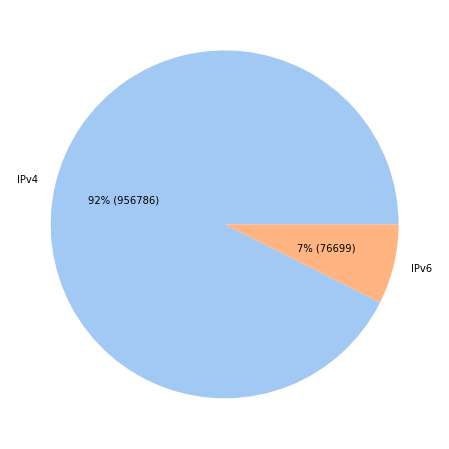

In [35]:
def label_v(val):
    return f'{str(int(val))}% ({str(int(np.round(val/100.*(len(df_4) + len(df_6)), 0)))})'

plt.pie([len(df_4), len(df_6)], labels = ['IPv4', 'IPv6'], autopct=label_v,
        colors = sns.color_palette('pastel')[0:2])
plt.show()

## Tree

In [9]:
sTree_4 = pytricia.PyTricia()
for index, row in df_4.iterrows():
    sTree_4.insert(row["prefix"], row["origin-as"])

#sTree_6 = pytricia.PyTricia()
#for index, row in df_6.iterrows():
#    sTree_6.insert(row["prefix"], row["origin-as"])

## Heatmap
Construct a heatmap by prefix overlapping each other.

In [65]:
heatmap = np.zeros((4096**2))
for index, row in df_4.iterrows():
    if (':') in row ["prefix"]:
        continue
        
    ip, prefix = row["prefix"].split('/')
    a = ip.split('.')
    start = (int(a[0]) * 2**16) + (int(a[1]) * 2**8) + int(a[2])
    end = start + 2**(24 - (int(prefix) if int(prefix) < 24 else 24))
    heatmap[start:end] += 1

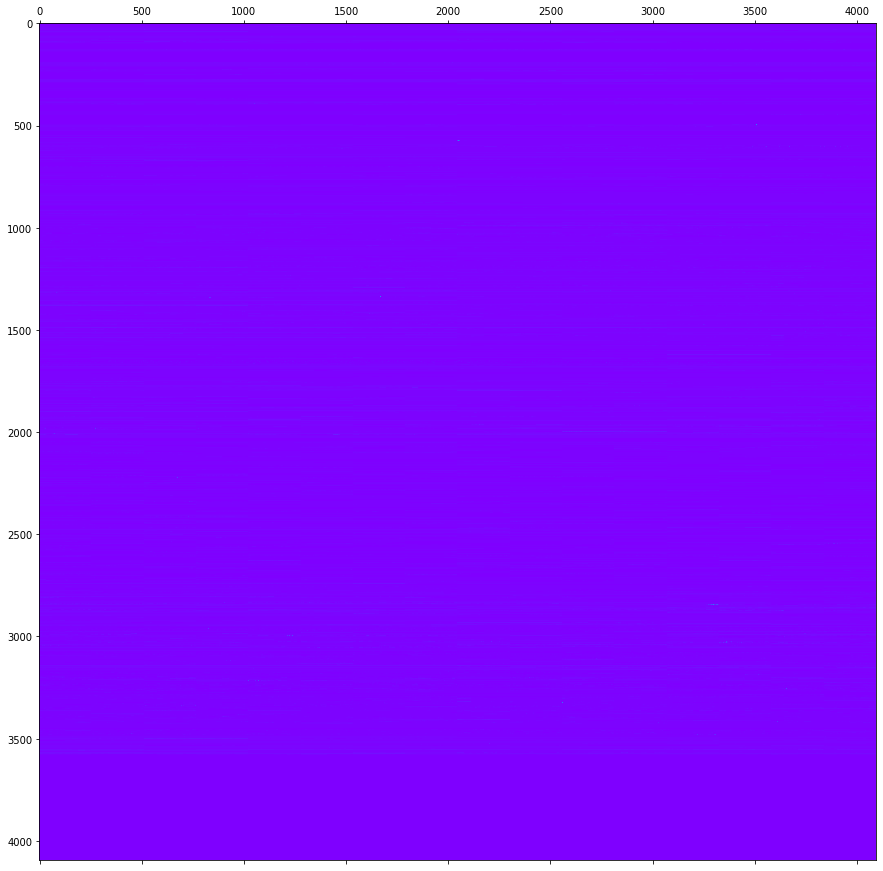

In [66]:
heatmap = heatmap.reshape((4096, 4096))
plt.rcParams["figure.figsize"] = [15.00, 15.00]
plt.matshow(heatmap, cmap="rainbow");

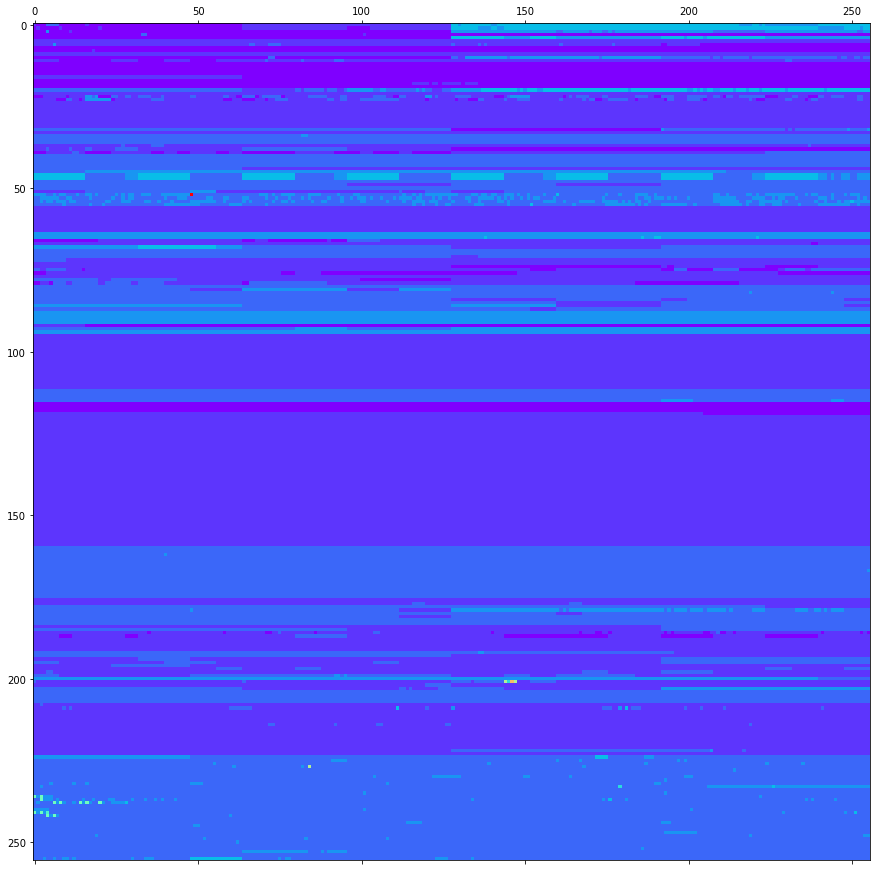

In [67]:
heatmap = heatmap.reshape((256, 256, 256))
plt.matshow(heatmap[1], cmap="rainbow");

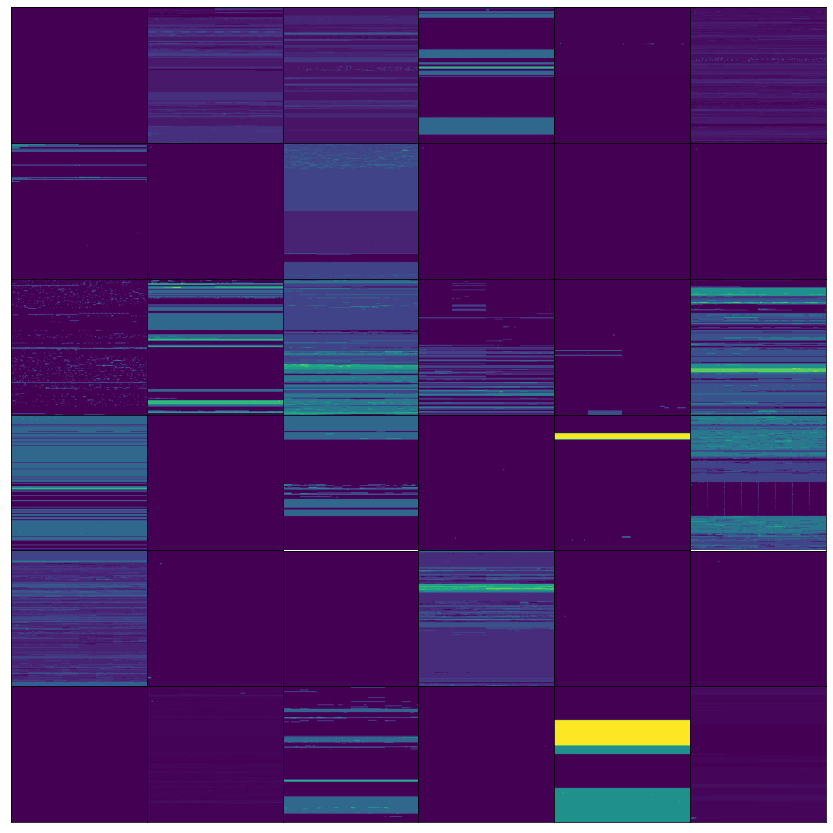

In [68]:
plt.rcParams["figure.figsize"] = [8.00, 8.00]
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 6), axes_pad=0)

for ax, im in zip(grid, heatmap[0:36]):
    ax.imshow(im)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
plt.show()

## Subnet Announcments by prefix len

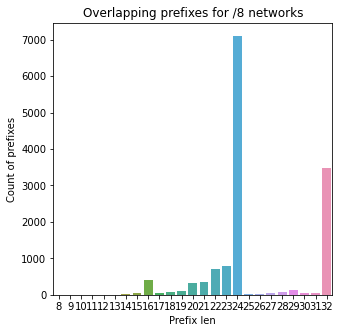

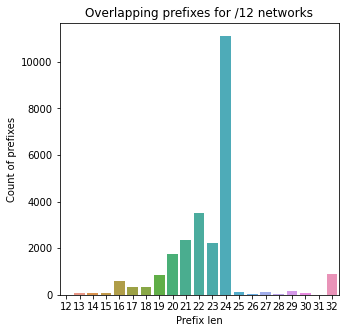

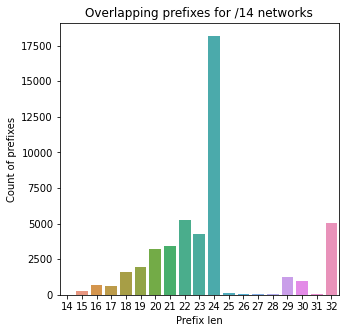

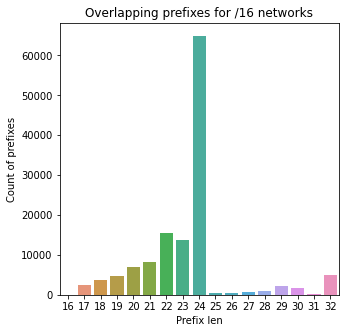

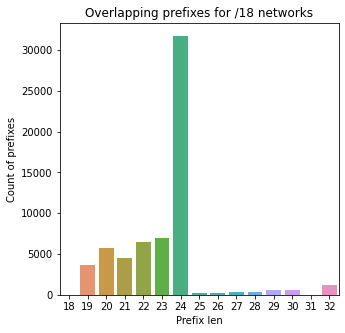

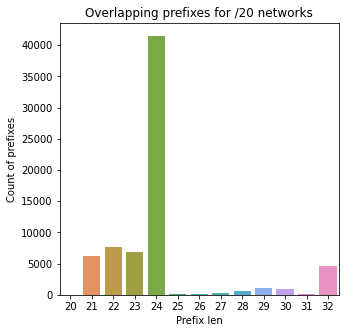

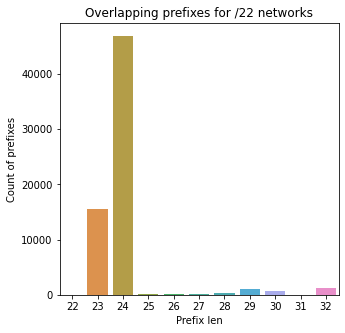

In [64]:
plt.rcParams["figure.figsize"] = [5.00, 5.00]


for size in [8, 12, 14, 16, 18, 20, 22]:
    bigP = df_4[df_4["prefix"].str.endswith('/'+str(size))]["prefix"].drop_duplicates()
    counts = []
    labels = []
    for i in range(size, 33):
        counts.append(0)
        labels.append(i)

    for p in bigP:
        for prefix in sTree_4.children(p):
            l = int(prefix.split('/')[1])
            if l <= 32:
                counts[l - size] += 1
    ax = sns.barplot(x=labels, y=counts).set(title=f'Overlapping prefixes for /{str(size)} networks',
                                             xlabel="Prefix len", ylabel = "Count of prefixes")
    plt.show()

## Traffic Engineering
### Prefix Len

In [ ]:
prefixes = list(sTree_4)
newTree = pytricia.PyTricia()

for p in prefixes:
    if (':' in p):
        continue
    children = sTree_4.children(p)
    origin = sTree_4[p]
    
    
    found = False
    
    for c in children:
        if (sTree_4[c] == origin):
            found = True
            newTree.insert(c, sTree_4[c])
            
    if found:
        newTree.insert(p, sTree_4[p])
    

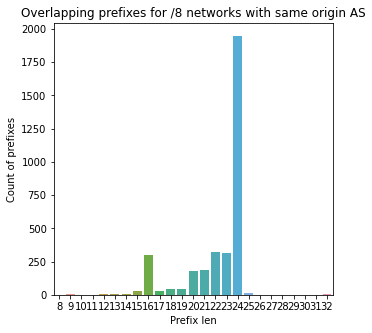

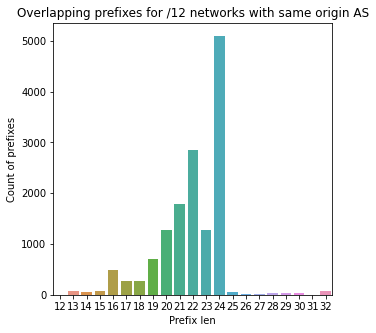

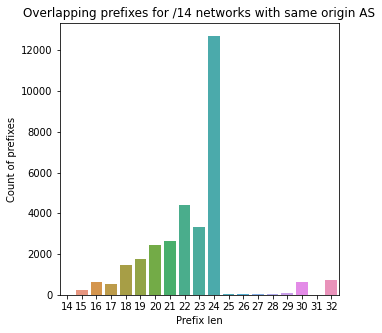

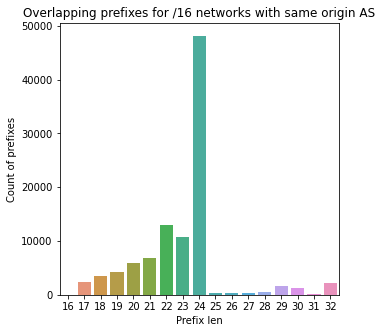

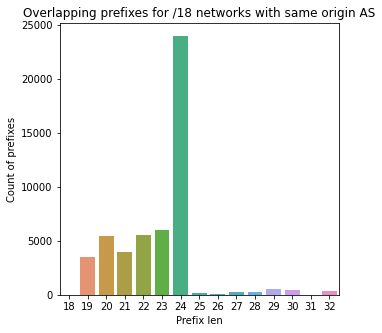

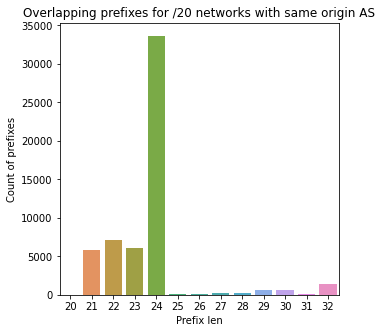

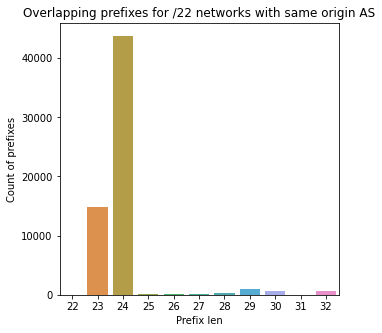

In [134]:
plt.rcParams["figure.figsize"] = [5.00, 5.00]
for size in [8, 12, 14, 16, 18, 20, 22]:
    bigP = df_4[df_4["prefix"].str.endswith('/'+str(size))]["prefix"].drop_duplicates()
    counts = []
    labels = []
    for i in range(size, 33):
        counts.append(0)
        labels.append(i)

    for p in bigP:
        if not newTree.has_key(p):
            continue
        for prefix in newTree.children(p):
            l = int(prefix.split('/')[1])
            if l <= 32:
                counts[l - size] += 1
    ax = sns.barplot(x=labels, y=counts).set(title=f'Overlapping prefixes for /{str(size)} networks with same origin AS',
                                             xlabel="Prefix len", ylabel = "Count of prefixes")
    plt.show()

In [57]:
heatmap = np.zeros((4096**2))
for p in list(newTree):
    if (':') in p:
        continue
        
    ip, prefix = p.split('/')
    a = ip.split('.')
    start = (int(a[0]) * 2**16) + (int(a[1]) * 2**8) + int(a[2])
    end = start + 2**(24 - (int(prefix) if int(prefix) < 24 else 24))
    heatmap[start:end] += 1

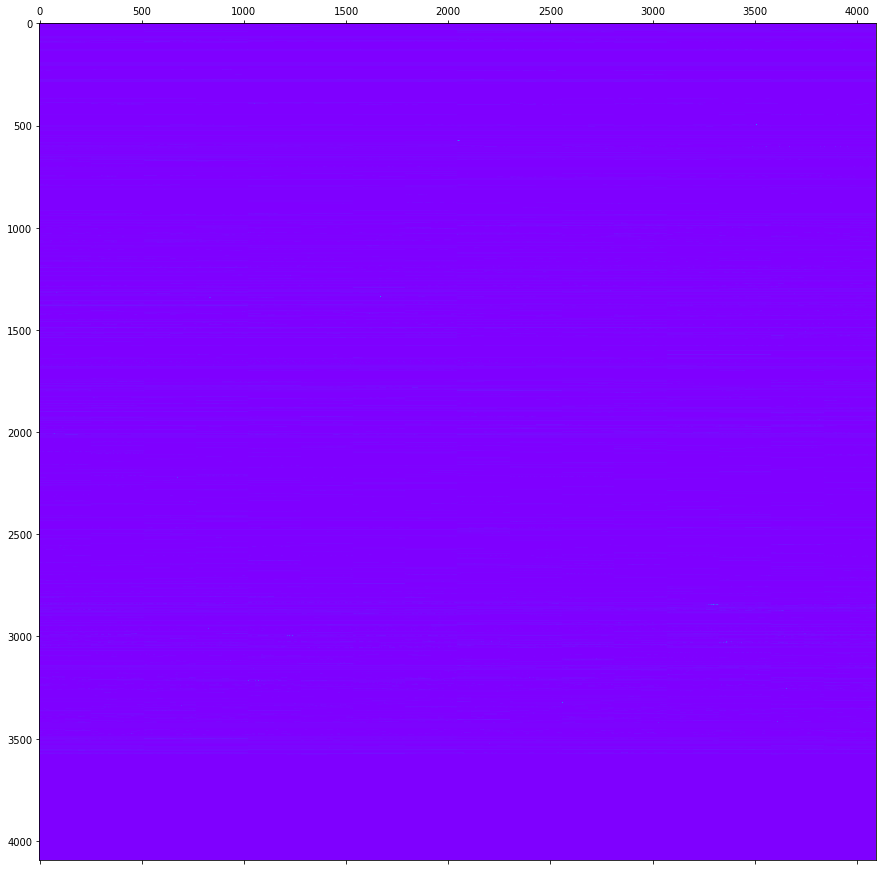

In [58]:
heatmap = heatmap.reshape((4096, 4096))
plt.rcParams["figure.figsize"] = [15.00, 15.00]
plt.matshow(heatmap, cmap="rainbow");

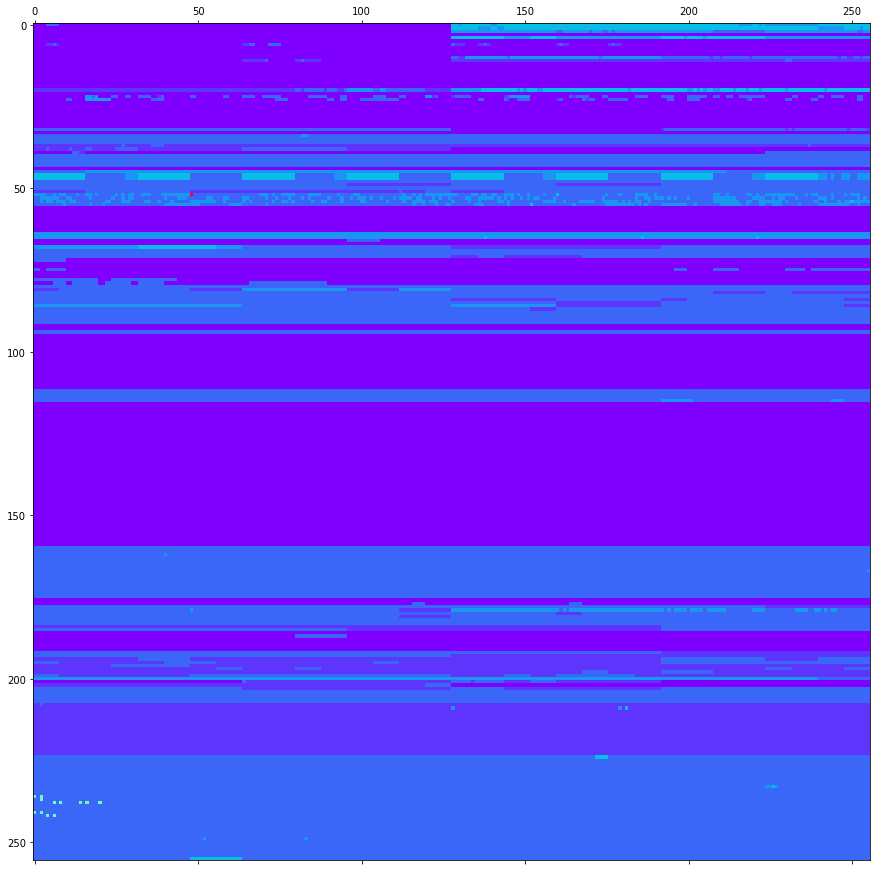

In [59]:
heatmap = heatmap.reshape((256, 256, 256))
plt.matshow(heatmap[1], cmap="rainbow");

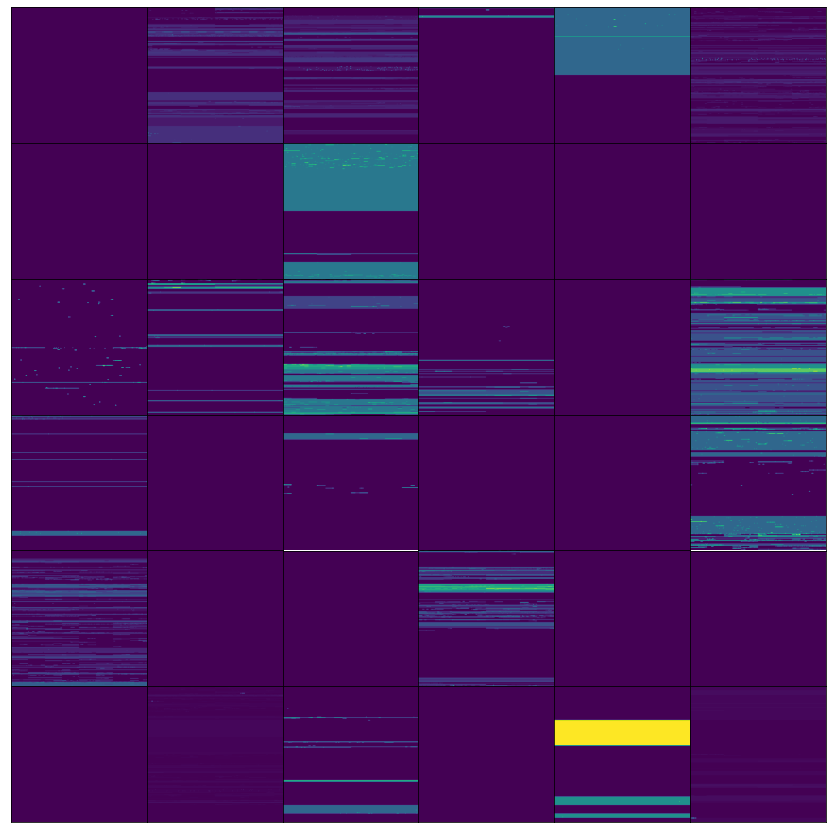

In [61]:
plt.rcParams["figure.figsize"] = [8.00, 8.00]
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 6), axes_pad=0)

for ax, im in zip(grid, heatmap[0:36]):
    ax.imshow(im)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
plt.show()

### AS Evaluation

In [73]:
as_num = []
for prefix in newTree:
    as_num.append(newTree[prefix])
as_num = pd.DataFrame (as_num, columns = ['AS'])
as_num.value_counts()

AS      
3549.0      10131
174.0        8820
3269.0       7114
12479.0      5319
4538.0       5288
            ...  
841.0           2
262909.0        2
262911.0        2
38379.0         2
10069.0         2
Length: 17036, dtype: int64

In [180]:
test = as_num.value_counts()

print()
txt = "{} {}, {:.2f}%, {}, {:.2f}%"

for i in [(1,5), (5,10), (10, 100), (100, 999999)]:
    print(txt.format(i, len(test[test.between(i[0], i[1])]),  len(test[test.between(i[0], i[1])])/len(test) * 100, 
    sum(test[test.between(i[0], i[1])]), sum(test[test.between(i[0], i[1])])/sum(test)* 100))



(1, 5) 8667, 50.87%, 29453, 6.56%
(5, 10) 5867, 34.44%, 38377, 8.55%
(10, 100) 4705, 27.62%, 123941, 27.61%
(100, 999999) 568, 3.33%, 273654, 60.97%
